Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [7]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = 'DeepLearning\\data' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified DeepLearning\data\notMNIST_large.tar.gz
Found and verified DeepLearning\data\notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labeled A through J.

In [8]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

DeepLearning\data\notMNIST_large already present - Skipping extraction of DeepLearning\data\notMNIST_large.tar.gz.
['DeepLearning\\data\\notMNIST_large\\A', 'DeepLearning\\data\\notMNIST_large\\B', 'DeepLearning\\data\\notMNIST_large\\C', 'DeepLearning\\data\\notMNIST_large\\D', 'DeepLearning\\data\\notMNIST_large\\E', 'DeepLearning\\data\\notMNIST_large\\F', 'DeepLearning\\data\\notMNIST_large\\G', 'DeepLearning\\data\\notMNIST_large\\H', 'DeepLearning\\data\\notMNIST_large\\I', 'DeepLearning\\data\\notMNIST_large\\J']
DeepLearning\data\notMNIST_small already present - Skipping extraction of DeepLearning\data\notMNIST_small.tar.gz.
['DeepLearning\\data\\notMNIST_small\\A', 'DeepLearning\\data\\notMNIST_small\\B', 'DeepLearning\\data\\notMNIST_small\\C', 'DeepLearning\\data\\notMNIST_small\\D', 'DeepLearning\\data\\notMNIST_small\\E', 'DeepLearning\\data\\notMNIST_small\\F', 'DeepLearning\\data\\notMNIST_small\\G', 'DeepLearning\\data\\notMNIST_small\\H', 'DeepLearning\\data\\notMNIST_

---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [9]:
from IPython.display import display, Image
display(Image(filename="DeepLearning\\data\\notMNIST_small\\A\\MDEtMDEtMDAudHRm.png"))


Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [10]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.


def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
    print (dataset.shape)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            # normalize to [-0.5 .. 0.5] range
            image_data = (imageio.imread(image_file).astype(float) -
                          pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except (IOError, ValueError) as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %
                        (num_images, min_num_images))
    
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset

def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
    
    return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)


Pickling DeepLearning\data\notMNIST_large\A.pickle.


(52912, 28, 28)
DeepLearning\data\notMNIST_large\A


Could not read: DeepLearning\data\notMNIST_large\A\RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.


Could not read: DeepLearning\data\notMNIST_large\A\SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.


Could not read: DeepLearning\data\notMNIST_large\A\Um9tYW5hIEJvbGQucGZi.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.


Full dataset tensor: (52909, 28, 28)
Mean: -0.12825


Standard deviation: 0.443121


Pickling DeepLearning\data\notMNIST_large\B.pickle.


(52912, 28, 28)
DeepLearning\data\notMNIST_large\B


Could not read: DeepLearning\data\notMNIST_large\B\TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.


Full dataset tensor: (52911, 28, 28)
Mean: -0.00756303


Standard deviation: 0.454491


Pickling DeepLearning\data\notMNIST_large\C.pickle.


(52912, 28, 28)
DeepLearning\data\notMNIST_large\C


Full dataset tensor: (52912, 28, 28)
Mean: -0.142258


Standard deviation: 0.439806


Pickling DeepLearning\data\notMNIST_large\D.pickle.


(52912, 28, 28)
DeepLearning\data\notMNIST_large\D


Could not read: DeepLearning\data\notMNIST_large\D\VHJhbnNpdCBCb2xkLnR0Zg==.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.


Full dataset tensor: (52911, 28, 28)
Mean: -0.0573678
Standard deviation: 0.455648


Pickling DeepLearning\data\notMNIST_large\E.pickle.


(52912, 28, 28)
DeepLearning\data\notMNIST_large\E


Full dataset tensor: (52912, 28, 28)
Mean: -0.069899


Standard deviation: 0.452942


Pickling DeepLearning\data\notMNIST_large\F.pickle.


(52912, 28, 28)
DeepLearning\data\notMNIST_large\F


Full dataset tensor: (52912, 28, 28)
Mean: -0.125583


Standard deviation: 0.44709


Pickling DeepLearning\data\notMNIST_large\G.pickle.


(52912, 28, 28)
DeepLearning\data\notMNIST_large\G


Full dataset tensor: (52912, 28, 28)
Mean: -0.0945814


Standard deviation: 0.44624


Pickling DeepLearning\data\notMNIST_large\H.pickle.


(52912, 28, 28)
DeepLearning\data\notMNIST_large\H


Full dataset tensor: (52912, 28, 28)
Mean: -0.0685221
Standard deviation: 0.454232


Pickling DeepLearning\data\notMNIST_large\I.pickle.


(52912, 28, 28)
DeepLearning\data\notMNIST_large\I


Full dataset tensor: (52912, 28, 28)
Mean: 0.0307862


Standard deviation: 0.468899


Pickling DeepLearning\data\notMNIST_large\J.pickle.


(52911, 28, 28)
DeepLearning\data\notMNIST_large\J


Full dataset tensor: (52911, 28, 28)
Mean: -0.153358


Standard deviation: 0.443656


Pickling DeepLearning\data\notMNIST_small\A.pickle.
(1873, 28, 28)
DeepLearning\data\notMNIST_small\A


Could not read: DeepLearning\data\notMNIST_small\A\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.


Full dataset tensor: (1872, 28, 28)
Mean: -0.132626
Standard deviation: 0.445128
Pickling DeepLearning\data\notMNIST_small\B.pickle.
(1873, 28, 28)
DeepLearning\data\notMNIST_small\B


Full dataset tensor: (1873, 28, 28)
Mean: 0.00535609
Standard deviation: 0.457115
Pickling DeepLearning\data\notMNIST_small\C.pickle.


(1873, 28, 28)
DeepLearning\data\notMNIST_small\C


Full dataset tensor: (1873, 28, 28)
Mean: -0.141521
Standard deviation: 0.44269
Pickling DeepLearning\data\notMNIST_small\D.pickle.
(1873, 28, 28)
DeepLearning\data\notMNIST_small\D


Full dataset tensor: (1873, 28, 28)
Mean: -0.0492167
Standard deviation: 0.459759
Pickling DeepLearning\data\notMNIST_small\E.pickle.
(1873, 28, 28)
DeepLearning\data\notMNIST_small\E


Full dataset tensor: (1873, 28, 28)
Mean: -0.0599148
Standard deviation: 0.45735
Pickling DeepLearning\data\notMNIST_small\F.pickle.
(1873, 28, 28)
DeepLearning\data\notMNIST_small\F


Could not read: DeepLearning\data\notMNIST_small\F\Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.


Full dataset tensor: (1872, 28, 28)
Mean: -0.118185
Standard deviation: 0.452279
Pickling DeepLearning\data\notMNIST_small\G.pickle.
(1872, 28, 28)
DeepLearning\data\notMNIST_small\G


Full dataset tensor: (1872, 28, 28)
Mean: -0.0925503
Standard deviation: 0.449006
Pickling DeepLearning\data\notMNIST_small\H.pickle.


(1872, 28, 28)
DeepLearning\data\notMNIST_small\H


Full dataset tensor: (1872, 28, 28)
Mean: -0.0586893
Standard deviation: 0.458759
Pickling DeepLearning\data\notMNIST_small\I.pickle.


(1872, 28, 28)
DeepLearning\data\notMNIST_small\I


Full dataset tensor: (1872, 28, 28)
Mean: 0.0526451
Standard deviation: 0.471894
Pickling DeepLearning\data\notMNIST_small\J.pickle.
(1872, 28, 28)
DeepLearning\data\notMNIST_small\J


Full dataset tensor: (1872, 28, 28)
Mean: -0.151689
Standard deviation: 0.448014


---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

DeepLearning\data\notMNIST_large\A.pickle


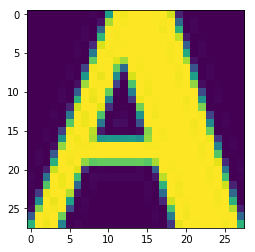

In [23]:
pickle_file = train_datasets[0]  # index 0 should be all As, 1 = all Bs, etc.
print(pickle_file)
with open(pickle_file, 'rb') as f:
    letter_set = pickle.load(f)  # unpickle
    sample_idx = np.random.randint(len(letter_set))  # pick a random image index
    sample_image = letter_set[sample_idx, :, :]  # extract a 2D slice
    plt.figure()
    plt.imshow(sample_image)

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [34]:
print("TEST DATASET")
for pickle_file in test_datasets:
    with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        print(pickle_file, ":", letter_set.shape)
print("TRAINING SET")
for pickle_file in train_datasets:
    with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        print(pickle_file, ":" ,letter_set.shape)

TEST DATASET
DeepLearning\data\notMNIST_small\A.pickle : (1872, 28, 28)
DeepLearning\data\notMNIST_small\B.pickle : (1873, 28, 28)
DeepLearning\data\notMNIST_small\C.pickle : (1873, 28, 28)
DeepLearning\data\notMNIST_small\D.pickle : (1873, 28, 28)
DeepLearning\data\notMNIST_small\E.pickle : (1873, 28, 28)
DeepLearning\data\notMNIST_small\F.pickle : (1872, 28, 28)
DeepLearning\data\notMNIST_small\G.pickle : (1872, 28, 28)
DeepLearning\data\notMNIST_small\H.pickle : (1872, 28, 28)
DeepLearning\data\notMNIST_small\I.pickle : (1872, 28, 28)
DeepLearning\data\notMNIST_small\J.pickle : (1872, 28, 28)
TRAINING SET


DeepLearning\data\notMNIST_large\A.pickle : (52909, 28, 28)


DeepLearning\data\notMNIST_large\B.pickle : (52911, 28, 28)


DeepLearning\data\notMNIST_large\C.pickle : (52912, 28, 28)


DeepLearning\data\notMNIST_large\D.pickle : (52911, 28, 28)


DeepLearning\data\notMNIST_large\E.pickle : (52912, 28, 28)


DeepLearning\data\notMNIST_large\F.pickle : (52912, 28, 28)


DeepLearning\data\notMNIST_large\G.pickle : (52912, 28, 28)


DeepLearning\data\notMNIST_large\H.pickle : (52912, 28, 28)


DeepLearning\data\notMNIST_large\I.pickle : (52912, 28, 28)


DeepLearning\data\notMNIST_large\J.pickle : (52911, 28, 28)


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [36]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [37]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)
Letter at  78267 : E
[ 0.35882354  0.24509804  0.18235295  0.19411765  0.19411765  0.19411765
  0.19411765  0.19411765  0.19411765  0.19411765  0.19411765  0.19411765
  0.19411765  0.19411765  0.19411765  0.19411765  0.19411765  0.19411765
  0.19411765  0.19411765  0.19411765  0.19411765  0.19411765  0.19411765
  0.19019608  0.2254902  -0.30784315 -0.5       ]


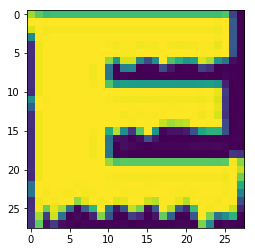

In [51]:
print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)
letters = ['A','B','C','D','E','F','G','H','I']
sample_idx = np.random.randint(train_labels.shape[0])  # pick a random image index
sample_image = train_dataset[sample_idx, :, :]  # extract a 2D slice
plt.figure()
plt.imshow(sample_image)
print("Letter at ",sample_idx,":", letters[train_labels[sample_idx]])
print(sample_image[0])

Finally, let's save the data for later reuse:

In [48]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [52]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800503


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [144]:
def find_overlap(A, B):

    if not A.dtype == B.dtype:
        raise TypeError("A and B must have the same dtype")
    if not A.shape[1:] == B.shape[1:]:
        raise ValueError("the shapes of A and B must be identical apart from "
                         "the row dimension")

    # reshape A and B to 2D arrays. force a copy if neccessary in order to
    # ensure that they are C-contiguous.
    A = np.ascontiguousarray(A.reshape(A.shape[0], -1))
    print ("A shape:", A.shape)
    B = np.ascontiguousarray(B.reshape(B.shape[0], -1))
    print ("B shape:", B.shape)
    # void type that views each row in A and B as a single item
    t = np.dtype((np.void, A.dtype.itemsize * A.shape[1]))
    print(t)
    # use in1d to find rows in A that are also in B
    # return np.in1d(A.view(t), B.view(t)), np.in1d(B.view(t), A.view(t))
    return np.in1d(A.view(t), B.view(t))


# find overlapping indices in valid dataset
valid_overlap = find_overlap(valid_dataset, train_dataset)
print("valid dataset overlapping count:", valid_dataset[valid_overlap].shape[0])
# print(valid_overlap.shape,"; ",np.where(valid_overlap==True))

# find overlapping indices in test dataset
test_overlap = find_overlap(test_dataset, train_dataset)
print("test dataset overlapping count:", test_dataset[test_overlap].shape[0])

# check overlapping indices in train dataset over valid dataset
ov = find_overlap(train_dataset,valid_dataset[valid_overlap])
print ("train x valid overlapping count:", train_dataset[ov].shape[0])


A shape: (10000, 784)
B shape: (200000, 784)
|V3136


valid dataset overlapping count: 1097
A shape: (10000, 784)
B shape: (200000, 784)
|V3136


test dataset overlapping count: 1301
A shape: (200000, 784)
B shape: (1097, 784)
|V3136


train x valid overlapping count: 3465


test_labels: (10000,) ;  7


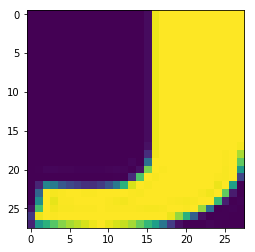

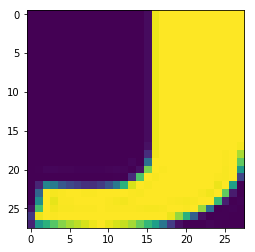

In [147]:
plt.figure()
plt.imshow(valid_dataset[ 9990,:,:])
plt.figure()
plt.imshow(train_dataset[ 177069,:,:])
print("test_labels:", test_labels.shape,"; ",test_labels[400])

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

DeepLearning\data\notMNIST.pickle


<built-in method keys of dict object at 0x00000000100287C8>


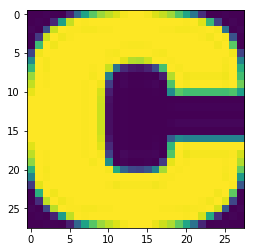

In [39]:
# Working with pickled dictionary
# {
#    'train_dataset': train_dataset,
#    'train_labels': train_labels,
#    'valid_dataset': valid_dataset,
#    'valid_labels': valid_labels,
#    'test_dataset': test_dataset,
#    'test_labels': test_labels,
#  } 

data_root = 'DeepLearning\\data'
pickle_file = os.path.join(data_root,"notMNIST.pickle")
print(pickle_file)
if not os.path.exists(pickle_file):
    raise Exception('File not exist: ', pickle_file)
f = open(pickle_file, 'rb')
letter_set = pickle.load(f)  # unpickle
print(letter_set.keys)

train_dataset = letter_set['train_dataset']
train_labels = letter_set['train_labels']
valid_dataset = letter_set['valid_dataset']
valid_labels = letter_set['test_dataset']
test_dataset = letter_set['test_dataset']
test_labels = letter_set['test_labels']
sample_idx = np.random.randint(len(train_dataset))  # pick a random image index
sample_image = train_dataset[sample_idx, :, :]  # extract a 2D slice
plt.figure()
plt.imshow(sample_image)

In [41]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression


def maybe_pickle(data, data_file, force=False):
    if os.path.exists(data_file) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping pickling.' % data_file)
    else:
        print('Pickling %s.' % data_file)
        with open(data_file, 'wb') as f:
            try:
                pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', data_file, ':', e)
    return True


def classifyNB(features_train, labels_train):
    # create classifier
    c = GaussianNB()
    # fit the classifier on the training features and labels
    # return the fit classifier
    return c.fit(features_train, labels_train)


def classifyLR(features_train, labels_train):
    # create classifier
    c = LogisticRegression()
    # fit the classifier on the training features and labels
    # return the fit classifier
    return c.fit(features_train, labels_train)


trainingset = train_dataset.reshape(train_dataset.shape[0], -1)
testset = test_dataset.reshape(test_dataset.shape[0], -1)
train_size = train_dataset.shape[0]
test_size = test_dataset.shape[0]
#print ("Start fit of Naive bayes")
#clfNB = classifyNB(trainingset[:train_size,:],train_labels[:train_size])
#accuracyNB = clfNB.score(testset[:test_size,:], test_labels[:test_size])
#print("Naive Base accuracy is ", accuracyNB)

#pickle_file = os.path.join(data_root,"clfNB.pickle")
#maybe_pickle(clfNB, pickle_file)

print("Start fit of Logistic regression")
clfLR = classifyLR(trainingset[:train_size, :], train_labels[:train_size])
print("End fit of Logistic regression")
accuracyLR = clfLR.score(testset[:test_size, :], test_labels[:test_size])
print("LogisticRegression is ", accuracyLR)
pickle_file = os.path.join(data_root, "clfLR.pickle")
maybe_pickle(clfLR, pickle_file, True)
print("Pickling is done ", pickle_file)

Start fit of Logistic regression


Prediction:  9
Prediction:  J


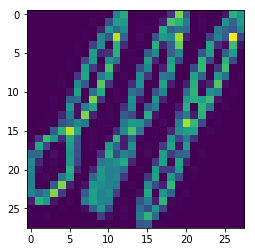

In [37]:
letters = ['A','B','C','D','E','F','G','H','I','J']
sample_idx = np.random.randint(testset.shape[0])  # pick a random image index
sample_image = test_dataset[sample_idx, :, :]  # extract a 2D slice
prediction = clfNB.predict(testset[sample_idx:sample_idx+1])
i = prediction[0]
print ("Prediction: ",i)
print("Prediction: ", letters[i])
plt.figure()
plt.imshow(sample_image)

In [34]:
def maybe_pickle(data, data_file, force=False):
    if os.path.exists(data_file) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping pickling.' % data_file)
    else:
        print('Pickling %s.' % data_file)
        with open(data_file, 'wb') as f:
            try:
                pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', data_file, ':', e)
    return True
    

pickle_file = os.path.join(data_root,"clfLR.pickle")
maybe_pickle(clfLR, pickle_file)

pickle_file = os.path.join(data_root,"clfNB.pickle")
maybe_pickle(clfNB, pickle_file)



DeepLearning\data\clfLR.pickle already present - Skipping pickling.


True

In [40]:
test_size = test_dataset.shape[0]
testset = test_dataset.reshape(test_dataset.shape[0], -1)
print("train size ", train_size)
print("test size ", test_size, " shape ", testset.shape, " labels ", test_labels)

accuracyNB = clfNB.score(testset, test_labels)
print("Naive Base accuracy is ", accuracyNB)

train size  200000
test size  10000  shape  (10000, 784)  labels  [9 6 2 ..., 5 1 5]


Naive Base accuracy is  0.8005
